<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/Burn/models/burn_cutmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import time
import os
import sys
import importlib.util
from pathlib import Path
from google.colab import drive

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.models import *


import numpy as np
import matplotlib.pyplot as plt


print("Fastai Version: ",fastai.__version__)

Fastai Version:  1.0.54


In [0]:
# Top level data directory. 

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
sys.path.append('/content/gdrive/My Drive')

Mounted at /content/drive


In [0]:
path = Path('/content/drive/My Drive/burn/burn_nosplit_final/')
path.ls()

[PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/1'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/2'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/3'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/none'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/models'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/burn_model_TL_imagenet.pth')]

In [0]:
import time 
start = time.time()
print(start)

1562381417.7035198


## Training and Predictions : ResNet34


In [0]:
tfms = get_transforms(flip_vert=True)
np.random.seed(0)
data1 = ImageDataBunch.from_folder(path, valid_pct=0.3, ds_tfms=tfms, size=224).normalize(imagenet_stats) 

Classes:  ['1', '2', '3', 'none']


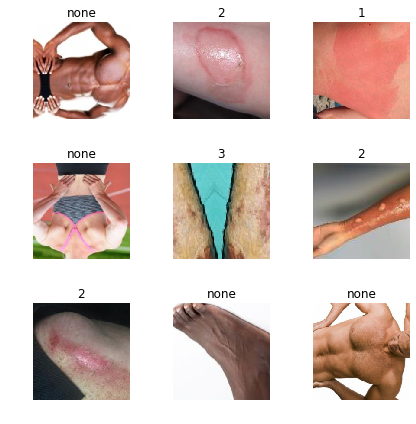

In [0]:
data1.show_batch(rows=3, figsize=(6, 6))
print('Classes: ',data1.classes)

In [0]:
learn_1 = cnn_learner(data1, models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


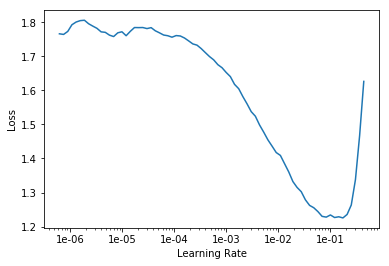

In [0]:
learn_1.lr_find()
learn_1.recorder.plot()

In [0]:
learn_1.fit_one_cycle(60, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1a')])

epoch,train_loss,valid_loss,accuracy,time
0,1.538538,1.156103,0.509009,00:41
1,1.376192,0.926699,0.612613,00:11
2,1.226348,0.805707,0.671171,00:11
3,1.108739,0.730031,0.711712,00:11
4,1.003483,0.677584,0.747748,00:11
5,0.909901,0.640319,0.797297,00:11
6,0.818749,0.624081,0.797297,00:11
7,0.754560,0.684363,0.738739,00:11
8,0.702285,0.736728,0.752252,00:11
9,0.644557,0.641686,0.765766,00:11


Better model found at epoch 0 with accuracy value: 0.5090090036392212.
Better model found at epoch 1 with accuracy value: 0.6126126050949097.
Better model found at epoch 2 with accuracy value: 0.6711711883544922.
Better model found at epoch 3 with accuracy value: 0.7117117047309875.
Better model found at epoch 4 with accuracy value: 0.7477477192878723.
Better model found at epoch 5 with accuracy value: 0.7972972989082336.
Better model found at epoch 45 with accuracy value: 0.8063063025474548.
Better model found at epoch 49 with accuracy value: 0.8108108043670654.


In [0]:
a = accuracy(*learn_1.get_preds())
print(a)

tensor(0.8108)


In [0]:
learn_1.save('burn_nosplit_final_defaultm')

In [0]:
# learn_1.unfreeze()

In [0]:
# learn_1.fit_one_cycle(5, slice(1e-3, 5e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1a')])

In [0]:
# a_unf = accuracy(*learn_1.get_preds())
# print(a_unf)

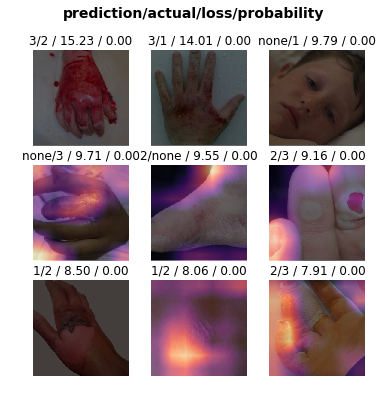

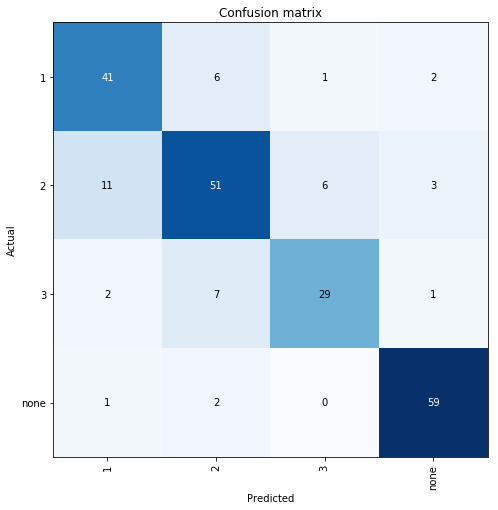

In [0]:
# Top Losses

interp = ClassificationInterpretation.from_learner(learn_1)
losses, idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(6, 6))
interp.plot_confusion_matrix(figsize=(7, 7))

## Training and Predictions : ResNet34 with mixup


In [0]:
learn_2 = cnn_learner(data1, models.resnet34, metrics=accuracy).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


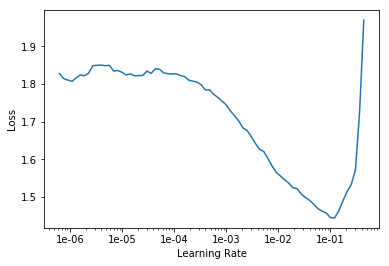

In [0]:
learn_2.lr_find()
learn_2.recorder.plot()

In [0]:
learn_2.fit_one_cycle(60, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_2, every='improvement', monitor='accuracy', name='best_2b')])

epoch,train_loss,valid_loss,accuracy,time
0,1.730712,1.123478,0.527027,00:11
1,1.543821,0.906079,0.666667,00:11
2,1.403442,0.772173,0.720721,00:11
3,1.305116,0.697459,0.743243,00:12
4,1.248178,0.650356,0.743243,00:11
5,1.197801,0.621822,0.770270,00:11
6,1.154137,0.614187,0.761261,00:11
7,1.096233,0.593110,0.743243,00:11
8,1.057215,0.618226,0.761261,00:11
9,1.032511,0.638872,0.756757,00:11


Better model found at epoch 0 with accuracy value: 0.5270270109176636.
Better model found at epoch 1 with accuracy value: 0.6666666865348816.
Better model found at epoch 2 with accuracy value: 0.7207207083702087.
Better model found at epoch 3 with accuracy value: 0.7432432174682617.
Better model found at epoch 5 with accuracy value: 0.7702702879905701.
Better model found at epoch 15 with accuracy value: 0.7747747898101807.
Better model found at epoch 21 with accuracy value: 0.7882882952690125.
Better model found at epoch 22 with accuracy value: 0.792792797088623.
Better model found at epoch 43 with accuracy value: 0.8108108043670654.


In [0]:
b = accuracy(*learn_2.get_preds())
print(b)

tensor(0.8108)


In [0]:
learn_2.save('burn_nosplit_final_mixup')

In [0]:
# learn_2.unfreeze()

In [0]:
# learn_2.fit_one_cycle(5, slice(1e-3, 5e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_2, every='improvement', monitor='accuracy', name='best_2b')])

In [0]:
# b_unf = accuracy(*learn_2.get_preds())
# print(b_unf)

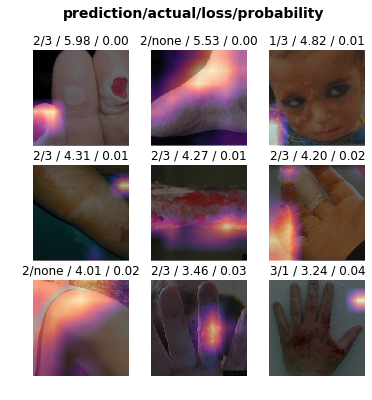

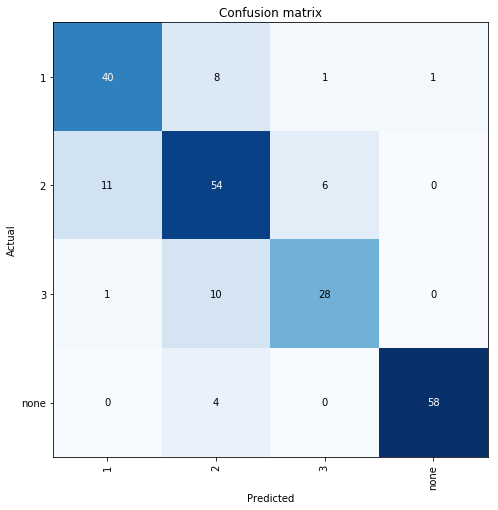

In [0]:
# Top Losses

interp = ClassificationInterpretation.from_learner(learn_2)
losses, idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(6, 6))
interp.plot_confusion_matrix(figsize=(7, 7))

## Training and Predictions : ResNet34 with cutmix


In [0]:
# CutMix 

from fastai.torch_core import *
from fastai.callback import *
from fastai.callbacks.mixup import MixUpLoss
from fastai.basic_train import Learner, LearnerCallback

class CutMixCallback(LearnerCallback):
    "Callback that creates the cutmixed input and target."
    def __init__(self, learn:Learner, α:float=1., stack_y:bool=True, true_λ:bool=True):
        super().__init__(learn)
        self.α,self.stack_y,self.true_λ = α,stack_y,true_λ

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train: return
        λ = np.random.beta(self.α, self.α)
        λ = max(λ, 1- λ)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        #Get new input
        last_input_size = last_input.shape
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input.size(), λ)
        new_input = last_input.clone()
        new_input[:, ..., bby1:bby2, bbx1:bbx2] = last_input[shuffle, ..., bby1:bby2, bbx1:bbx2]
        λ = last_input.new([λ])
        if self.true_λ:
            λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
            λ = last_input.new([λ])
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)
        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, α:float=1., stack_x:bool=False, stack_y:bool=True, true_λ:bool=True) -> Learner:
    "Add mixup https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, α=α, stack_y=stack_y, true_λ=true_λ))
    return learn

Learner.cutmix = cutmix

In [0]:
learn_3 = cnn_learner(data1, models.resnet34, metrics=accuracy).cutmix()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


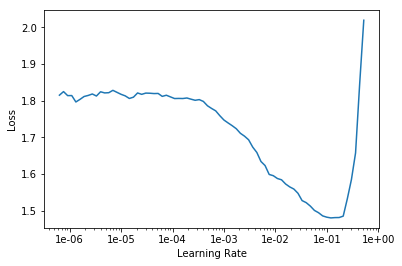

In [0]:
learn_3.lr_find()
learn_3.recorder.plot()

In [0]:
learn_3.fit_one_cycle(60, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_3, every='improvement', monitor='accuracy', name='best_3c')])

epoch,train_loss,valid_loss,accuracy,time
0,1.716292,1.204153,0.495495,00:11
1,1.564300,1.005926,0.630631,00:11
2,1.459512,0.872069,0.653153,00:11
3,1.379539,0.771650,0.707207,00:11
4,1.317684,0.684642,0.729730,00:11
5,1.303210,0.650579,0.738739,00:11
6,1.237029,0.638522,0.725225,00:11
7,1.187705,0.635391,0.743243,00:11
8,1.125859,0.593579,0.747748,00:11
9,1.096167,0.601437,0.761261,00:11


Better model found at epoch 0 with accuracy value: 0.4954954981803894.
Better model found at epoch 1 with accuracy value: 0.630630612373352.
Better model found at epoch 2 with accuracy value: 0.6531531810760498.
Better model found at epoch 3 with accuracy value: 0.707207202911377.
Better model found at epoch 4 with accuracy value: 0.7297297120094299.
Better model found at epoch 5 with accuracy value: 0.7387387156486511.
Better model found at epoch 7 with accuracy value: 0.7432432174682617.
Better model found at epoch 8 with accuracy value: 0.7477477192878723.
Better model found at epoch 9 with accuracy value: 0.7612612843513489.
Better model found at epoch 14 with accuracy value: 0.7972972989082336.
Better model found at epoch 31 with accuracy value: 0.8018018007278442.


In [0]:
c = accuracy(*learn_3.get_preds())
print(c)

tensor(0.8018)


In [0]:
learn_3.save('burn_nosplit_final_mixup')

In [0]:
# learn_3.unfreeze()

In [0]:
# learn_3.fit_one_cycle(5, slice(1e-3, 5e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_3, every='improvement', monitor='accuracy', name='best_3c')])

In [0]:
# c_unf = accuracy(*learn_3.get_preds())
# print(c_unf)

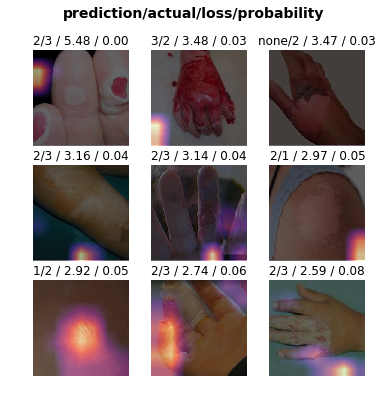

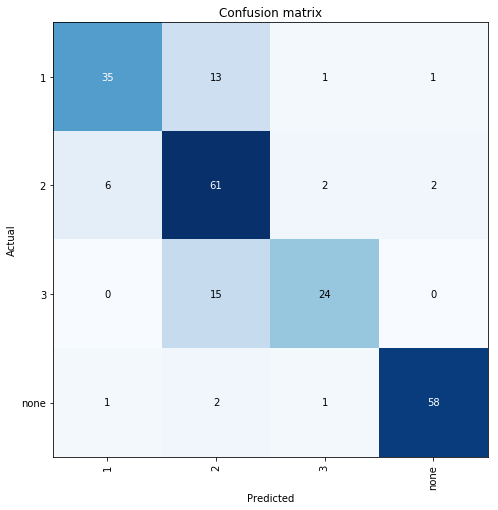

In [0]:
# Top Losses

interp = ClassificationInterpretation.from_learner(learn_3)
losses, idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(6, 6))
interp.plot_confusion_matrix(figsize=(7, 7))

In [0]:
print((time.time()-start)/60)

40.67537306149801


In [0]:
print(a, b, c ) #accuracies

tensor(0.8108) tensor(0.8108) tensor(0.8018)


* with 5 epochs  ~ 10 min: tensor(0.6937) tensor(0.6486) tensor(0.6892)  i.e.  default > cutmix > mixup



* with 30 epochs  ~ 42 min : tensor(0.7838) tensor(0.8063) tensor(0.8063) i.e. default < mixup = cutmix



* with 60 epochs  ~ 51 min : tensor(0.8198) tensor(0.8153) tensor(0.8108) i.e default > mixup > cutmix


Note: In the original paper [cutmix](https://github.com/clovaai/CutMix-PyTorch), number of epochs = 300.

